In [89]:
# import sys
# !{sys.executable} -m pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

# Get data

In [2]:
df = pd.read_csv('./../../labeledTweets/allLabeledTweets.csv')
df = df[['id', 'message', 'label']]
df.head()

,id,message,label
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0


In [3]:
df['label'].value_counts()

0    968
2    647
1    410
Name: label, dtype: int64

In [4]:
newLine ="\\n|\\r"
urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = '\d+((\.|\-)\d+)?'
mentions = '\B\@([\w\-]+)'
hashtag = '#'
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

df['clean_message'] = df['message']
df['clean_message'] = df['clean_message'].str.replace(newLine,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(urls,' URL ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(mentions,' MENTION ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(numbers,' NMBR ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(hashtag,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(whitespaces,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(leadTrailWhitespace,'',regex=True)

df.head()

,id,message,label,clean_message
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0,Augulis: airBaltic “potenciālie pircēji ir no ...
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,MENTION MENTION MENTION Netrāpīs kādam AirBalt...


# Train, validate split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [6]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

id  message  clean_message
label data_type                             
0     train      823      823            823
      val        145      145            145
1     train      348      348            348
      val         62       62             62
2     train      550      550            550
      val         97       97             97

In [7]:
df.head()

,id,message,label,clean_message,data_type
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...,train
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0,Augulis: airBaltic “potenciālie pircēji ir no ...,val
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...,train
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...,train
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,MENTION MENTION MENTION Netrāpīs kādam AirBalt...,train


## Balance training data

In [8]:
df[df.data_type=='train']['label'].value_counts()

0    823
2    550
1    348
Name: label, dtype: int64

In [9]:
df_train = [df[df.data_type=='train'].clean_message, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["clean_message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_1.shape[0], random_state=42)
df_2_downsampled = df_2.sample(df_1.shape[0], random_state=42)

df_train = pd.concat([df_0_downsampled, df_2_downsampled, df_1])

df_train['label'].value_counts()

0    348
1    348
2    348
Name: label, dtype: int64

In [10]:
# Shuffle rows
import sklearn

df_train = sklearn.utils.shuffle(df_train, random_state=0)

df_train.head()

,clean_message,label
700,Šodien norisinās SEB MTB maratons. Finišs MENT...,0
1911,MENTION Sveiks! Tas neattiecas uz mūsu ekspert...,1
505,"MENTION MENTION Starpcitu, Maxima tirgo labus ...",1
1471,Taisnība ir uzvarējusi! Martins Dukurs kļūst p...,1
1537,MENTION Спасибо за мнение.^el,0


# Tokenizer "bert-base-multilingual-cased"

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

## Add emoji

In [12]:
import re

emoji_str = "😀 😃 😄 😁 😆 😅 😂 🤣 😊 😇 🙂 🙃 😉 😌 😍 🥰 😘 😗 😙 😚 😋 😛 😝 😜 🤪 🤨 🧐 🤓 😎 🤩 🥳 😏 😒 😞 😔 😟 😕 🙁 ☹️ 😣 😖 😫 😩 🥺 😢 😭 😤 😠 😡 🤬 🤯 😳 🥵 🥶 😱 😨 😰 😥 😓 🤗 🤔 🤭 🤫 🤥 😶 😐 😑 😬 🙄 😯 😦 😧 😮 😲 🥱 😴 🤤 😪 😵 🤐 🥴 🤢 🤮 🤧 😷 🤒 🤕 😺 😸 😹 😻 😼 😽 🙀 😿 😾 💩 👋 🤚 🖐 ✋ 🖖 👌 🤏 ✌️ 🤞 🤟 🤘 🤙 👈 👉 👆 🖕 👇 ☝️ 👍 👎 ✊ 👊 🤛 🤜 👏 🙌 👐 🤲 🤝 🙏'👋🏻 🤚🏻 🖐🏻 ✋🏻 🖖🏻 👌🏻 🤏🏻 ✌🏻 🤞🏻 🤟🏻 🤘🏻 🤙🏻 👈🏻 👉🏻 👆🏻 🖕🏻 👇🏻 ☝🏻 👍🏻 👎🏻 ✊🏻 👊🏻 🤛🏻 🤜🏻 👏🏻 🙌🏻 👐🏻 🤲🏻 🙏🏻 👋🏼 🤚🏼 🖐🏼 ✋🏼 🖖🏼 👌🏼 🤏🏼 ✌🏼 🤞🏼 🤟🏼 🤘🏼 🤙🏼 👈🏼 👉🏼 👆🏼 🖕🏼 👇🏼 ☝🏼 👍🏼 👎🏼 ✊🏼 👊🏼 🤛🏼 🤜🏼 👏🏼 🙌🏼 👐🏼 🤲🏼 🙏🏼 👋🏽 🤚🏽 🖐🏽 ✋🏽 🖖🏽 👌🏽 🤏🏽 ✌🏽 🤞🏽 🤟🏽 🤘🏽 🤙🏽 👈🏽 👉🏽 👆🏽 🖕🏽 👇🏽 ☝🏽 👍🏽 👎🏽 ✊🏽 👊🏽 🤛🏽 🤜🏽 👏🏽 🙌🏽 👐🏽 🤲🏽 🙏👋🏾 🤚🏾 🖐🏾 ✋🏾 🖖🏾 👌🏾 🤏🏾 ✌🏾 🤞🏾 🤟🏾 🤘🏾 🤙🏾 👈🏾 👉🏾 👆🏾 🖕🏾 👇🏾 ☝🏾 👍🏾 👎🏾 ✊🏾 👊🏾 🤛🏾 🤜🏾 👏🏾 🙌🏾 👐🏾 🤲🏾 🙏 👋🏿 🤚🏿 🖐🏿 ✋🏿 🖖🏿 👌🏿 🤏🏿 ✌🏿 🤞🏿 🤟🏿 🤘🏿 🤙🏿 👈🏿 👉🏿 👆🏿 🖕🏿 👇🏿 ☝🏿 👍🏿 👎🏿 ✊🏿 👊🏿 🤛🏿 🤜🏿 👏🏿 🙌🏿 👐🏿 🤲🏿 🙏🏿 ❤️ 🧡 💛 💚 💙 💜 🖤 🤍 🤎 💔 ❣️ 💕 💞 💓 💗 💖 💘 💝 💟 💑🏻 💑🏼 💑🏽 💑🏾 💑🏿 💏🏻 💏🏼 💏🏽 💏🏾 💏🏿 👨🏻‍❤️‍👨🏻 👨🏻‍❤️‍👨🏼 👨🏻‍❤️‍👨🏽 👨🏻‍❤️‍👨🏾 👨🏻‍❤️‍👨🏿 👨🏼‍❤️‍👨🏻 👨🏼‍❤️‍👨🏼 👨🏼‍❤️‍👨🏽 👨🏼‍❤️‍👨🏾 👨🏼‍❤️‍👨🏿 👨🏽‍❤️‍👨🏻 👨🏽‍❤️‍👨🏼 👨🏽‍❤️‍👨🏽 👨🏽‍❤️‍👨🏾 👨🏽‍❤️‍👨🏿 👨🏾‍❤️‍👨🏻 👨🏾‍❤️‍👨🏼 👨🏾‍❤️‍👨🏽 👨🏾‍❤️‍👨🏾 👨🏾‍❤️‍👨🏿 👨🏿‍❤️‍👨🏻 👨🏿‍❤️‍👨🏼 👨🏿‍❤️‍👨🏽 👨🏿‍❤️‍👨🏾 👨🏿‍❤️‍👨🏿 👩🏻‍❤️‍👨🏻 👩🏻‍❤️‍👨🏼 👩🏻‍❤️‍👨🏽 👩🏻‍❤️‍👨🏾 👩🏻‍❤️‍👨🏿 👩🏻‍❤️‍👩🏻 👩🏻‍❤️‍👩🏼 👩🏻‍❤️‍👩🏽 👩🏻‍❤️‍👩🏾 👩🏻‍❤️‍👩🏿 👩🏼‍❤️‍👨🏻 👩🏼‍❤️‍👨🏼 👩🏼‍❤️‍👨🏽 👩🏼‍❤️‍👨🏾 👩🏼‍❤️‍👨🏿 👩🏼‍❤️‍👩🏻 👩🏼‍❤️‍👩🏼 👩🏼‍❤️‍👩🏽 👩🏼‍❤️‍👩🏾 👩🏼‍❤️‍👩🏿 👩🏽‍❤️‍👨🏻 👩🏽‍❤️‍👨🏼 👩🏽‍❤️‍👨🏽 👩🏽‍❤️‍👨🏾 👩🏽‍❤️‍👨🏿 👩🏽‍❤️‍👩🏻 👩🏽‍❤️‍👩🏼 👩🏽‍❤️‍👩🏽 👩🏽‍❤️‍👩🏾 👩🏽‍❤️‍👩🏿 👩🏾‍❤️‍👨🏻 👩🏾‍❤️‍👨🏼 👩🏾‍❤️‍👨🏽 👩🏾‍❤️‍👨🏾 👩🏾‍❤️‍👨🏿 👩🏾‍❤️‍👩🏻 👩🏾‍❤️‍👩🏼 👩🏾‍❤️‍👩🏽 👩🏾‍❤️‍👩🏾 👩🏾‍❤️‍👩🏿 👩🏿‍❤️‍👨🏻 👩🏿‍❤️‍👨🏼 👩🏿‍❤️‍👨🏽 👩🏿‍❤️‍👨🏾 👩🏿‍❤️‍👨🏿 👩🏿‍❤️‍👩🏻 👩🏿‍❤️‍👩🏼 👩🏿‍❤️‍👩🏽 👩🏿‍❤️‍👩🏾 👩🏿‍❤️‍👩🏿 🧑🏻‍❤️‍🧑🏼 🧑🏻‍❤️‍🧑🏽 🧑🏻‍❤️‍🧑🏾 🧑🏻‍❤️‍🧑🏿 🧑🏼‍❤️‍🧑🏻 🧑🏼‍❤️‍🧑🏽 🧑🏼‍❤️‍🧑🏾 🧑🏼‍❤️‍🧑🏿 🧑🏽‍❤️‍🧑🏻 🧑🏽‍❤️‍🧑🏼 🧑🏽‍❤️‍🧑🏾 🧑🏽‍❤️‍🧑🏿 🧑🏾‍❤️‍🧑🏻 🧑🏾‍❤️‍🧑🏼 🧑🏾‍❤️‍🧑🏽 🧑🏾‍❤️‍🧑🏿 🧑🏿‍❤️‍🧑🏻 🧑🏿‍❤️‍🧑🏼 🧑🏿‍❤️‍🧑🏽 🧑🏿‍❤️‍🧑🏾 👨🏻‍❤️‍💋‍👨🏻 👨🏻‍❤️‍💋‍👨🏼 👨🏻‍❤️‍💋‍👨🏽 👨🏻‍❤️‍💋‍👨🏾 👨🏻‍❤️‍💋‍👨🏿 👨🏼‍❤️‍💋‍👨🏻 👨🏼‍❤️‍💋‍👨🏼 👨🏼‍❤️‍💋‍👨🏽 👨🏼‍❤️‍💋‍👨🏾 👨🏼‍❤️‍💋‍👨🏿 👨🏽‍❤️‍💋‍👨🏻 👨🏽‍❤️‍💋‍👨🏼 👨🏽‍❤️‍💋‍👨🏽 👨🏽‍❤️‍💋‍👨🏾 👨🏽‍❤️‍💋‍👨🏿 👨🏾‍❤️‍💋‍👨🏻 👨🏾‍❤️‍💋‍👨🏼 👨🏾‍❤️‍💋‍👨🏽 👨🏾‍❤️‍💋‍👨🏾 👨🏾‍❤️‍💋‍👨🏿 👨🏿‍❤️‍💋‍👨🏻 👨🏿‍❤️‍💋‍👨🏼 👨🏿‍❤️‍💋‍👨🏽 👨🏿‍❤️‍💋‍👨🏾 👨🏿‍❤️‍💋‍👨🏿 👩🏻‍❤️‍💋‍👨🏻 👩🏻‍❤️‍💋‍👨🏼 👩🏻‍❤️‍💋‍👨🏽 👩🏻‍❤️‍💋‍👨🏾 👩🏻‍❤️‍💋‍👨🏿 👩🏻‍❤️‍💋‍👩🏻 👩🏻‍❤️‍💋‍👩🏼 👩🏻‍❤️‍💋‍👩🏽 👩🏻‍❤️‍💋‍👩🏾 👩🏻‍❤️‍💋‍👩🏿 👩🏼‍❤️‍💋‍👨🏻 👩🏼‍❤️‍💋‍👨🏼 👩🏼‍❤️‍💋‍👨🏽 👩🏼‍❤️‍💋‍👨🏾 👩🏼‍❤️‍💋‍👨🏿 👩🏼‍❤️‍💋‍👩🏻 👩🏼‍❤️‍💋‍👩🏼 👩🏼‍❤️‍💋‍👩🏽 👩🏼‍❤️‍💋‍👩🏾 👩🏼‍❤️‍💋‍👩🏿 👩🏽‍❤️‍💋‍👨🏻 👩🏽‍❤️‍💋‍👨🏼 👩🏽‍❤️‍💋‍👨🏽 👩🏽‍❤️‍💋‍👨🏾 👩🏽‍❤️‍💋‍👨🏿 👩🏽‍❤️‍💋‍👩🏻 👩🏽‍❤️‍💋‍👩🏼 👩🏽‍❤️‍💋‍👩🏽 👩🏽‍❤️‍💋‍👩🏾 👩🏽‍❤️‍💋‍👩🏿 👩🏾‍❤️‍💋‍👨🏻 👩🏾‍❤️‍💋‍👨🏼 👩🏾‍❤️‍💋‍👨🏽 👩🏾‍❤️‍💋‍👨🏾 👩🏾‍❤️‍💋‍👨🏿 👩🏾‍❤️‍💋‍👩🏻 👩🏾‍❤️‍💋‍👩🏼 👩🏾‍❤️‍💋‍👩🏽 👩🏾‍❤️‍💋‍👩🏾 👩🏾‍❤️‍💋‍👩🏿 👩🏿‍❤️‍💋‍👨🏻 👩🏿‍❤️‍💋‍👨🏼 👩🏿‍❤️‍💋‍👨🏽 👩🏿‍❤️‍💋‍👨🏾 👩🏿‍❤️‍💋‍👨🏿 👩🏿‍❤️‍💋‍👩🏻 👩🏿‍❤️‍💋‍👩🏼 👩🏿‍❤️‍💋‍👩🏽 👩🏿‍❤️‍💋‍👩🏾 👩🏿‍❤️‍💋‍👩🏿 🧑🏻‍❤️‍💋‍🧑🏼 🧑🏻‍❤️‍💋‍🧑🏽 🧑🏻‍❤️‍💋‍🧑🏾 🧑🏻‍❤️‍💋‍🧑🏿 🧑🏼‍❤️‍💋‍🧑🏻 🧑🏼‍❤️‍💋‍🧑🏽 🧑🏼‍❤️‍💋‍🧑🏾 🧑🏼‍❤️‍💋‍🧑🏿 🧑🏽‍❤️‍💋‍🧑🏻 🧑🏽‍❤️‍💋‍🧑🏼 🧑🏽‍❤️‍💋‍🧑🏾 🧑🏽‍❤️‍💋‍🧑🏿 🧑🏾‍❤️‍💋‍🧑🏻 🧑🏾‍❤️‍💋‍🧑🏼 🧑🏾‍❤️‍💋‍🧑🏽 🧑🏾‍❤️‍💋‍🧑🏿 🧑🏿‍❤️‍💋‍🧑🏻 🧑🏿‍❤️‍💋‍🧑🏼 🧑🏿‍❤️‍💋‍🧑🏽 🧑🏿‍❤️‍💋‍🧑🏾 👭 🧑‍🤝‍🧑 👬 👫 👩‍❤️‍👩 💑 👨‍❤️‍👨 👩‍❤️‍👨 👩‍❤️‍💋‍👩 💏 👨‍❤️‍💋‍👨 👩‍❤️‍💋‍👨 👪 👨‍👩‍👦 👨‍👩‍👧 👨‍👩‍👧‍👦 👨‍👩‍👦‍👦 👨‍👩‍👧‍👧 👨‍👨‍👦 👨‍👨‍👧 👨‍👨‍👧‍👦 👨‍👨‍👦‍👦 👨‍👨‍👧‍👧 👩‍👩‍👦 👩‍👩‍👧 👩‍👩‍👧‍👦 👩‍👩‍👦‍👦 👩‍👩‍👧‍👧 👨‍👦 👨‍👦‍👦 👨‍👧 👨‍👧‍👦 👨‍👧‍👧 👩‍👦 👩‍👦‍👦 👩‍👧 👩‍👧‍👦 👩‍ 👧‍👧 💋"
emoji_list = emoji_str.split(' ')
emoji_regex = '|'.join(emoji_list)

In [13]:
all_emoji = []
for message in df.clean_message:
    foundEmoji = re.findall(emoji_regex, message)
    for emoji in foundEmoji:
        all_emoji.append(emoji)

print(len(all_emoji))

107


In [14]:
import collections

counter=collections.Counter(all_emoji)
print(counter.most_common(100))

most_common_values= [word for word, word_count in counter.most_common(100)]

[('😂', 12), ('🤔', 9), ('😁', 9), ('👍', 7), ('👉', 6), ('🙄', 6), ('😀', 5), ('😉', 5), ('😎', 5), ('😊', 4), ('🤗', 3), ('😅', 3), ('👏', 3), ('❤️', 3), ('😥', 2), ('😵', 2), ('😍', 2), ('😆', 2), ('🤘', 2), ('🤬', 2), ('🙂', 2), ('😖', 1), ('🤥', 1), ('☝️', 1), ('🙁', 1), ('🤣', 1), ('😳', 1), ('🙌', 1), ('👌', 1), ('🤓', 1), ('😌', 1), ('🤢', 1), ('👇', 1), ('😜', 1)]


In [15]:
c=[('😂', 6968), ('😭', 4638), ('🤣', 2528), ('🙏', 1916), ('🥺', 1084), ('😩', 1058), ('🤔', 903), ('🥰', 899), ('🥴', 869), ('👏', 840), ('😍', 838), ('🙄', 775), ('🙌', 672), ('💙', 639), ('😅', 568), ('💜', 543), ('💕', 540), ('😊', 509), ('👍', 477), ('😘', 474), ('😔', 464), ('💔', 454), ('😒', 446), ('🙃', 425), ('😎', 398), ('😉', 388), ('😁', 365), ('😢', 359), ('😌', 355), ('🖤', 347), ('😆', 310), ('🤗', 307), ('😳', 298), ('🥳', 292), ('✊', 289), ('😤', 289), ('💛', 288), ('😬', 282), ('🤬', 281), ('👇', 271), ('😡', 266), ('👌', 265), ('🤩', 265), ('💖', 259), ('😫', 255), ('💋', 251), ('\U0001f90d', 250), ('💚', 231), ('💗', 217), ('🙂', 212), ('😞', 206), ('😷', 202), ('🤯', 202), ('😀', 193), ('😴', 188), ('😋', 185), ('😏', 179), ('🤞', 174), ('😜', 174), ('👉', 168), ('🤘', 154), ('😪', 154), ('🤤', 154), ('😑', 152), ('🤪', 152), ('😐', 141), ('😱', 139), ('😄', 132), ('👊', 128), ('🤢', 122), ('🤨', 121), ('🧐', 120), ('🥶', 116), ('😕', 115), ('💩', 113), ('😇', 112), ('🤮', 109), ('🥵', 106), ('🤧', 104), ('👋', 103), ('👎', 99), ('😖', 97), ('🤓', 96), ('😃', 96), ('\U0001f971', 94), ('💞', 93), ('😓', 91), ('🤝', 90), ('🧡', 89), ('😹', 86), ('🖕', 85), ('😝', 84), ('😣', 75), ('🤫', 71), ('😰', 71), ('😥', 70), ('🤭', 70), ('💓', 59), ('😠', 58), ('😮', 55)]
most_common_values=[word for word, word_count in c]

In [16]:
len(tokenizer)

119547

In [17]:
tokenizer.add_tokens(most_common_values, special_tokens=True)

100

In [18]:
len(tokenizer)

119647

### Find max length for tokenizer

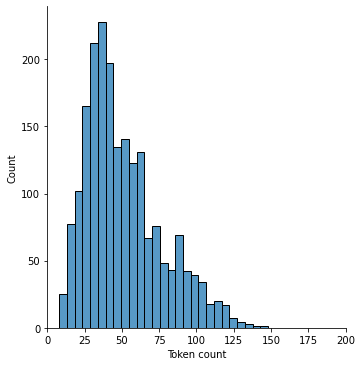

In [19]:
token_lens = []
for txt in list(df.clean_message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')
plt.show()

In [20]:
max_length = 150

### Encode messages

In [21]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train["clean_message"].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].clean_message.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\aligo\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
len(dataset_train), len(dataset_val)

(1044, 304)

# Model "bert-base-multilingual-cased"

In [23]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [24]:
model.resize_token_embeddings(len(tokenizer))

Embedding(119647, 768)

In [25]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [26]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

In [27]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [28]:
# Function to measure weighted F1

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [29]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model.to(device)
print(device)

cpu


In [30]:
# Function to evaluate model. Returns average validation loss, predictions, true values

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    progress_bar = tqdm(dataloader_val, desc='Validating', leave=False, disable=False)
    for batch in progress_bar:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Evaluate model trained on PNN dataset on LV Twitter data

In [34]:
model.load_state_dict(torch.load('modelsEmoji-pnn/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

from sklearn.metrics import classification_report, confusion_matrix

preds_flat = np.argmax(predictions, axis=1).flatten()

In [31]:
val_f1 = f1_score_func(predictions, true_vals)
print('F1:')
print(val_f1)
print(classification_report(true_vals, preds_flat))
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

F1:
0.3703206958497119
              precision    recall  f1-score   support

           0       0.49      0.95      0.64       145
           1       0.40      0.03      0.06        62
           2       0.60      0.09      0.16        97

    accuracy                           0.49       304
   macro avg       0.50      0.36      0.29       304
weighted avg       0.50      0.49      0.37       304



predicted                  
                  neutral positive negative
actual neutral        138        3        4
       positive        58        2        2
       negative        88        0        9

# Train

In [35]:
from tqdm.notebook import tqdm

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'modelsEmojiTwttrPNN/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    
    print('Classification report:')
    print(classification_report(true_vals, preds_flat))
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
            index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
            columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))
    print('--------------------------------------------------------------')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.1191846529642742


Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.900631594657898
F1 Score (Weighted): 0.6399500438904134
Classification report:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       145
           1       0.51      0.68      0.58        62
           2       0.65      0.57      0.60        97

    accuracy                           0.64       304
   macro avg       0.62      0.64      0.63       304
weighted avg       0.65      0.64      0.64       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         97       28       20
       positive        10       42       10
       negative        30       12       55
--------------------------------------------------------------


Epoch 2:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8604503364273997


Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.8192062735557556
F1 Score (Weighted): 0.6559622755135298
Classification report:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       145
           1       0.56      0.65      0.60        62
           2       0.65      0.64      0.65        97

    accuracy                           0.65       304
   macro avg       0.64      0.65      0.64       304
weighted avg       0.66      0.65      0.66       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         97       24       24
       positive        13       40        9
       negative        27        8       62
--------------------------------------------------------------


Epoch 3:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.7635758483048641


Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.8163271546363831
F1 Score (Weighted): 0.6560258340182796
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.61      0.67       145
           1       0.55      0.68      0.60        62
           2       0.64      0.71      0.67        97

    accuracy                           0.65       304
   macro avg       0.64      0.67      0.65       304
weighted avg       0.67      0.65      0.66       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         88       27       30
       positive        11       42        9
       negative        20        8       69
--------------------------------------------------------------


Epoch 4:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.7192385124437737


Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.8227700412273407
F1 Score (Weighted): 0.6566465216907444
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.61      0.67       145
           1       0.54      0.69      0.61        62
           2       0.64      0.70      0.67        97

    accuracy                           0.65       304
   macro avg       0.64      0.67      0.65       304
weighted avg       0.67      0.65      0.66       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         88       28       29
       positive         9       43       10
       negative        20        9       68
--------------------------------------------------------------


Epoch 5:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.6990855462623365


Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.8227700412273407
F1 Score (Weighted): 0.6566465216907444
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.61      0.67       145
           1       0.54      0.69      0.61        62
           2       0.64      0.70      0.67        97

    accuracy                           0.65       304
   macro avg       0.64      0.67      0.65       304
weighted avg       0.67      0.65      0.66       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         88       28       29
       positive         9       43       10
       negative        20        9       68
--------------------------------------------------------------


# Evaluate

In [ ]:
model.load_state_dict(torch.load('modelsUNKTwttrPNN/finetuned_BERT_epoch_X.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
preds_flat = np.argmax(predictions, axis=1).flatten()

In [ ]:
print(classification_report(true_vals, preds_flat))

In [ ]:
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]